# Image Transforms Manager

This is the "Image" version of transform manager.

**IMPORTANT:**: **Image**(ItemBase) 
+ All the image transformations are meant to operate on an **Image** and produce an **Image**.
+ Usually the transformations operate "in place", remember to clone the input **Image** before apply the tfms if you want to keep the original.  
+ The array of transformations (ie data augemtation) is not applied directly calling all the functions by hand, but is applied using the method **apply_tfms** from **Image**. This is made to ensure that some constraints are met (ie: order of tfms, the precence of crop_padding, etc..)
+ All the transformations have an "order" property that is used from the **apply_tfms** function to ensure that certain operations have the correct order (ie: pad_crop should be the last one to ensure that everything has the same "size")
+ Validation Transforms have always the "crop_pad" pass

**For all the above reasons, usually all the image transformations are applied all in a single pass.**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Export

#Internal dependencies
from exp.nb_AudioCommon import * 
from exp.nb_DataAugmentation import * 
from exp.nb_FastWidgets import * 
from exp.nb_TransformsManager import * 

In [3]:
#Export
from fastai.vision import *
from fastai import *

### Image Sample Data

In [4]:
path = untar_data(URLs.PETS);

In [5]:
image = open_image(path/'images/Ragdoll_83.jpg')

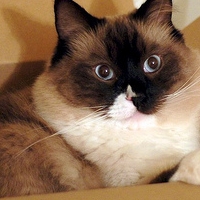

In [6]:
crop_pad(image.clone(),200) #

## ImageTfmsManager

In [7]:
#Export
class ImageTfmsManager(TfmsManager):
    '''Group schema 0:PRE 1:AUG 2:POST'''
    
    def get_data_augmentation_tfms(self):
        return getTfmList(self.train_tfmsg[(1):]) # all tfmsg up to 1
    
    def try_tfms(self, src:Image, tfms, showInput=True, showResults=True, repeats=3, **kwargs):
        '''Try to apply transformationas'''
        ys = [src.apply_tfms(tfms) for i in range(repeats)] # y is an image..
        for y in ys:
            assert y is not None, 'No data after transform'
        
        if showResults: 
            imgW=self.getImageWidget(dsts=ys,src=src if showInput else None,**kwargs)
            display(getResultAndTfmsWidget(imgW,tfms))
        return y

    def getImageWidget(self, dsts:Image , src:Image=None,**kwargs):
        srcW = getImageWidget(src.data) if src is not None else widgets.Output()
        dstsArr = []
        for dst in dsts:
            dstW = getImageWidget(dst.data) if dst is not None else widgets.Output()
            diffW = fastLabel('SAME',background_color=None)
            if (src is not None) and (dst is not None):
                diffImg = (dst.data - src.data).abs().clamp(0,1)
                if diffImg.sum()>0:
                    diffW = getImageWidget(diffImg)
            dstsArr.append(widgets.HBox([dstW,diffW]))
        dstsW = widgets.VBox(children=dstsArr)
        return widgets.HBox(children=[fastCard("SOURCE",srcW),fastCard("DESTINATION",dstsW)])
    
    def try_train_tfms(self, src:Image, lbl:str=None, showResults=True, repeats=4, **kwargs):
        '''Try to apply all train transforms'''
        y=src

        #preR = widgets.Output()
        #with preR:
        #    y=self.try_tfms(y, flatten(self.train_tfmsg[0]),showResults=True,repeats=1,**kwargs) #Only one needed?
            
        augR = widgets.Output()
        with augR:
            y=self.try_tfms(y, flatten(self.train_tfmsg),showResults=True,repeats=repeats,**kwargs)
        
        #preW = fastCard('INITIAL CROP: (Image)', preR, text_align='left', title_background_color='lavender')
        augW = fastCard('DATA AUGMENTATION: (Image using apply_tfms):', augR, text_align='left', title_background_color='lavender')

        wFooter = fastCard(f'RESULT: type={type(y)} shape={y.data.shape}', text_align='left', title_background_color=None)
        
        out = display(fastCard(lbl,widgets.VBox(children=[augW,wFooter]),
                               color='white',title_background_color='black'))
        display(out)
        return y        
        
    @classmethod
    def get_from_default_tfms(cls,fastai_tfms):
        '''Factory to create a tfm manager from default fastai get_tfms(...) function'''        
        apply = sortByTfmOrderAttr(fastai_tfms[0])
        applyV = sortByTfmOrderAttr(fastai_tfms[1])
        return cls([apply],[applyV])

In [8]:
#Show all results
tfms = get_transforms() # default
tm=ImageTfmsManager.get_from_default_tfms(tfms)

len(tm.train_tfmsg), len(tm.valid_tfmsg) 

tm.try_train_tfms(image,'Sample with single RGB');

None

### ImageTfmsManager sample usage:
Tune data augmentation.

In [9]:
#Show all results
tfms = get_transforms(
    do_flip = False, 
    flip_vert = False,
    max_rotate = 1,
    max_zoom = 1.0  
)
tm=ImageTfmsManager.get_from_default_tfms(tfms)
tm.try_train_tfms(image,'Sample with single RGB',repeats=8);

None

In [10]:
#Show all results
tfms = get_transforms(
    do_flip = True, 
    flip_vert = True,
    max_rotate = 30.0,
    max_zoom = 1.2, 
    max_lighting = 0.8, 
    max_warp = 0.2, 
    p_affine = 0.75, 
    p_lighting = 0.75   
)
tm=ImageTfmsManager.get_from_default_tfms(tfms)
tm.try_train_tfms(image,'Sample with single RGB',repeats=8);

None

In [11]:
#Original fast ai tfms...
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.1985715517706207, 'col_pct': 0.34259111313160184, 'padding_mode': 'reflection'}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 0}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([-0.1763,  0.0780, -0.1271, -0.0885]), 'invert': False}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-30.0, 30.0)}, p=0.75, resolved={'degrees': 24.000611189298738}, do_run=False, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.2), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={'scale': 1.0621793013161174, 'row_pct': 0.4388947590396983, 'col_pct': 0.15251288826730625}, do_run=True, is_random=True),
  RandTransform(

In [12]:
#Result coputed from ImageTfmsManager
#IMPORTANT: in tfms manager all the tfms are ordered by ".tfm.order" field
tm.get_tfms()

[[RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={'magnitude': tensor([-0.1763,  0.0780, -0.1271, -0.0885]), 'invert': False}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 0}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-30.0, 30.0)}, p=0.75, resolved={'degrees': 24.000611189298738}, do_run=False, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.2), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={'scale': 1.0621793013161174, 'row_pct': 0.4388947590396983, 'col_pct': 0.15251288826730625}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.09999999999999998, 0.9)}, p=0.75, resolved={'change': 0.8323566640724415}, do_run=False, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.19999999999999996, 5.000000000000001)

# Export

In [13]:
!python notebook2script.py AudioTransformsManager.ipynb

Converted AudioTransformsManager.ipynb to nb_AudioTransformsManager.py
